# Warehouse Operations — Guided Colab Lab (3 Hours) — Dashboard + Scenarios

This notebook is designed to be **interactive and visual**.
It produces dashboard-style charts and connects slides → KPIs → scenarios → decisions.

Scope  
Warehouse execution only (order flow, productivity, congestion)

Analytics Flow  
Descriptive → Diagnostic → Predictive → Prescriptive


## Hands-On Table (Follow in Order)

| Step | What | Cell ID | What to do in Colab | Why (Purpose) |
|---|---|---|---|---|
| 0A | Load and inspect dataset | `0A` | Run cell, inspect `df.head()` and `df.columns` | Understand execution fields |
| 0B | Identify variable roles | `0B` | Fill STATE / FLOW / CONSTRAINT lists | Build system mental model |
| 1A | Construct cycle time KPI | `1A` | Set `CYCLE_START`, `CYCLE_END` | Measure execution speed |
| 1B | Build daily baseline table | `1B` | Run aggregation | Baseline for dashboards |
| 1C | Dashboard charts (baseline) | `1C` | Run plots | Make warehouse KPIs visual |
| 2A | Build pick rate from pick work time | `2A` | Set `PICK_START`, `PICK_END` | Capacity input from work time |
| 2B | Utilization + WIP proxy | `2B` | Define arrival/capacity, compute KPIs | Congestion diagnosis |
| 2C | Dashboard charts (congestion) | `2C` | Run plots + scatter | Link utilization to delay |
| 3A | Predictive Scenario A: uniform demand shock | `3A` | Set `DEMAND_MULTIPLIER` | Show proportional scaling |
| 3B | Predictive Scenario B: peak-day shock | `3B` | Set `PEAK_DAY_MULTIPLIER` and weekday | Make utilization change non-uniform |
| 3C | Predictive + congestion: cycle time response | `3C` | Enable `CONGESTION_MODEL_ON` | Show non-linear dashboard movement |
| 4A | Prescriptive: target utilization | `4A` | Set `TARGET_UTIL` | Decision goal |
| 4B | Prescriptive: required staffing by day | `4B` | Compute workers_required + gap | Actionable plan |


## Step 0A — Load and Inspect Dataset

**Cell ID:** `0A`

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 160)

df = pd.read_csv("https://raw.githubusercontent.com/saikisri97/17_Hof_Lecture_Code_Pingo/refs/heads/main/Supply_Chain_Analytics/data/warehouse_ops_orders_class_v2.csv")


for c in ["Date","Order_Time","Pick_Start","Pick_End","Ship_Time"]:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors="coerce")

display(df.head(5))
print("\nColumns:", list(df.columns))
print("\nRows:", len(df))


,Order_ID,Date,Week_Num,SKU,Zone,Order_Time,Pick_Start,Pick_End,Ship_Time,Picks,Workers_On_Shift,Shift_Hours,Demand,Receipt_Qty,On_Hand_Inventory,Backorder_Qty,Is_Promo,Price,On_Order_Qty,Lead_Time_Days
0,WO000001,2024-01-01,1,SKU-INV-001,A,2024-01-01 12:04:34.371709988,2024-01-01 12:22:04.707434858,2024-01-01 12:27:23.456944007,2024-01-01 12:47:37.758316628,40,8,8.12,23.0,83.0,360.0,0.0,NaN,NaN,0.0,7.0
1,WO000002,2024-01-01,1,SKU-INV-001,B,2024-01-01 14:31:33.811356105,2024-01-01 14:47:16.663750715,2024-01-01 14:53:13.985610003,2024-01-01 15:28:40.143464557,14,8,8.12,23.0,83.0,360.0,0.0,NaN,NaN,0.0,7.0
2,WO000003,2024-01-01,1,SKU-INV-001,A,2024-01-01 09:21:23.120473445,2024-01-01 09:45:44.409387040,2024-01-01 09:48:14.409387040,2024-01-01 10:30:22.181918453,14,8,8.12,23.0,83.0,360.0,0.0,NaN,NaN,0.0,7.0
3,WO000004,2024-01-01,1,SKU-INV-001,C,2024-01-01 11:27:53.585366230,2024-01-01 11:34:45.424021159,2024-01-01 11:41:55.565324070,2024-01-01 12:09:04.791376229,27,8,8.12,23.0,83.0,360.0,0.0,NaN,NaN,0.0,7.0
4,WO000005,2024-01-01,1,SKU-INV-001,A,2024-01-01 13:01:37.628705527,2024-01-01 13:12:16.734844509,2024-01-01 13:17:33.431139791,2024-01-01 13:35:00.961321182,27,8,8.12,23.0,83.0,360.0,0.0,NaN,NaN,0.0,7.0



Columns: ['Order_ID', 'Date', 'Week_Num', 'SKU', 'Zone', 'Order_Time', 'Pick_Start', 'Pick_End', 'Ship_Time', 'Picks', 'Workers_On_Shift', 'Shift_Hours', 'Demand', 'Receipt_Qty', 'On_Hand_Inventory', 'Backorder_Qty', 'Is_Promo', 'Price', 'On_Order_Qty', 'Lead_Time_Days']

Rows: 1966


## Step 0B — Identify Variable Roles

**Cell ID:** `0B`

Fill lists with column names from `df.columns`.

In [2]:
STATE_VARIABLES = ["Picks"]
FLOW_VARIABLES = ["Order_Time", "Pick_Start", "Pick_End", "Ship_Time"]
CONSTRAINT_VARIABLES = ["Workers_On_Shift", "Shift_Hours", "Zone"]

STATE_VARIABLES, FLOW_VARIABLES, CONSTRAINT_VARIABLES


(['Picks'],
 ['Order_Time', 'Pick_Start', 'Pick_End', 'Ship_Time'],
 ['Workers_On_Shift', 'Shift_Hours', 'Zone'])

## Step 1A — Construct Warehouse Cycle Time (Execution)

**Cell ID:** `1A`

Cycle time is execution lead time (order release → ship).

In [3]:
CYCLE_START = "Order_Time"
CYCLE_END = "Ship_Time"

df["wh_cycle_time_hrs"] = (
    pd.to_datetime(df[CYCLE_END]) - pd.to_datetime(df[CYCLE_START])
).dt.total_seconds() / 3600

df_kpi = df[df["wh_cycle_time_hrs"].notna() & (df["wh_cycle_time_hrs"] >= 0)].copy()
df_kpi["wh_cycle_time_hrs"].describe()


count    1966.000000
mean        0.810355
std         0.181275
min         0.275298
25%         0.683420
50%         0.808304
75%         0.935419
max         1.455974
Name: wh_cycle_time_hrs, dtype: float64

## Step 1B — Daily Baseline Table

**Cell ID:** `1B`

In [4]:
df_kpi["day"] = df_kpi["Date"].dt.date

daily = df_kpi.groupby("day").agg(
    orders=("Order_ID","nunique"),
    total_picks=("Picks","sum"),
    avg_cycle_time_hrs=("wh_cycle_time_hrs","mean"),
    p90_cycle_time_hrs=("wh_cycle_time_hrs", lambda s: np.percentile(s.dropna(), 90)),
    workers=("Workers_On_Shift","median"),
    shift_hours=("Shift_Hours","median")
).reset_index()

daily["orders_per_hr"] = daily["orders"] / daily["shift_hours"]
daily["picks_per_hr"] = daily["total_picks"] / daily["shift_hours"]

display(daily.head(10))


,day,orders,total_picks,avg_cycle_time_hrs,p90_cycle_time_hrs,workers,shift_hours,orders_per_hr,picks_per_hr
0,2024-01-01,10,296,0.740396,0.971557,8.0,8.12,1.231527,36.453202
1,2024-01-02,17,198,0.830293,1.096297,11.0,8.04,2.114428,24.626866
2,2024-01-03,15,210,0.793457,0.948761,10.0,8.17,1.835985,25.703794
3,2024-01-04,16,260,0.873308,1.099166,10.0,7.89,2.027883,32.953105
4,2024-01-05,17,204,0.796552,1.050746,9.0,8.04,2.114428,25.373134
5,2024-01-06,12,162,0.845824,1.032656,7.0,8.16,1.470588,19.852941
6,2024-01-07,10,152,0.822221,1.062799,4.0,7.92,1.262626,19.191919
7,2024-01-08,15,301,0.841605,1.001696,10.0,8.11,1.849568,37.114673
8,2024-01-09,12,198,0.804026,0.959201,9.0,7.83,1.532567,25.287356
9,2024-01-10,8,190,0.774324,0.908416,9.0,7.91,1.011378,24.020228


## Step 1C — Baseline Dashboard Charts

**Cell ID:** `1C`

Common warehouse dashboard views: time series + distribution.

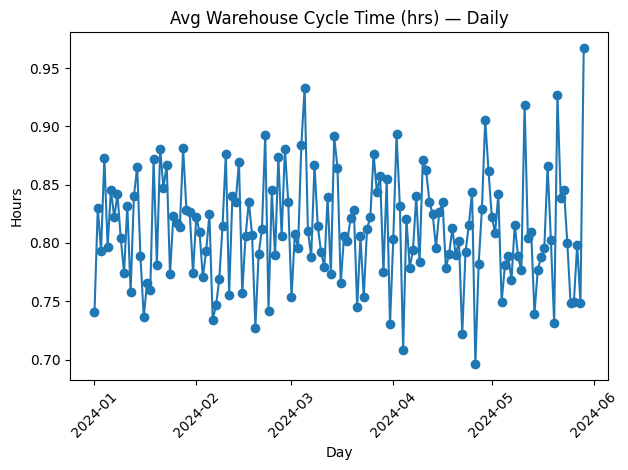

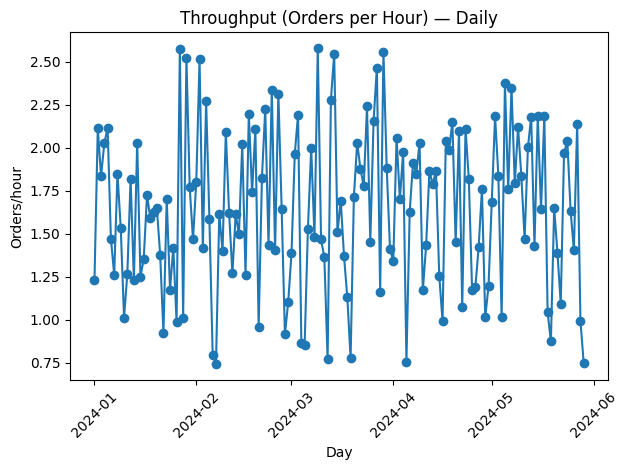

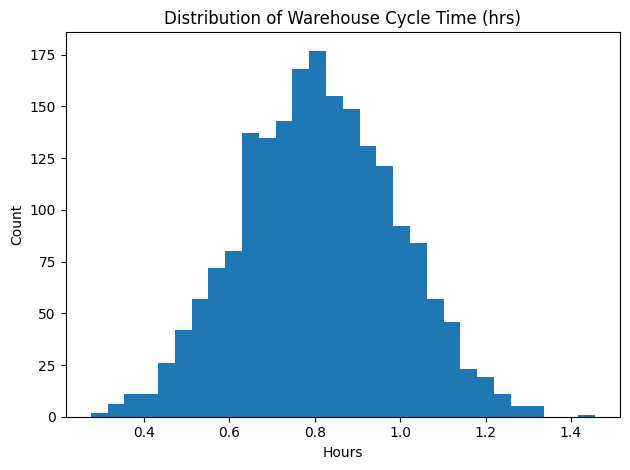

In [5]:
# Time series: avg cycle time
plt.figure()
plt.plot(pd.to_datetime(daily["day"]), daily["avg_cycle_time_hrs"], marker="o")
plt.title("Avg Warehouse Cycle Time (hrs) — Daily")
plt.xlabel("Day")
plt.ylabel("Hours")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Time series: orders per hour
plt.figure()
plt.plot(pd.to_datetime(daily["day"]), daily["orders_per_hr"], marker="o")
plt.title("Throughput (Orders per Hour) — Daily")
plt.xlabel("Day")
plt.ylabel("Orders/hour")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Distribution: cycle time
plt.figure()
plt.hist(df_kpi["wh_cycle_time_hrs"].dropna(), bins=30)
plt.title("Distribution of Warehouse Cycle Time (hrs)")
plt.xlabel("Hours")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


## Step 2A — Pick Work Time and Pick Rate

**Cell ID:** `2A`

Pick rate is computed from **work time**, not from total picks alone.

In [6]:
PICK_START = "Pick_Start"
PICK_END = "Pick_End"

df_kpi["pick_work_hrs"] = (
    pd.to_datetime(df_kpi[PICK_END]) - pd.to_datetime(df_kpi[PICK_START])
).dt.total_seconds() / 3600

df_kpi = df_kpi[df_kpi["pick_work_hrs"].notna() & (df_kpi["pick_work_hrs"] > 0)].copy()

pick_daily = df_kpi.groupby("day").agg(
    pick_work_hrs=("pick_work_hrs","sum"),
    picks=("Picks","sum")
).reset_index()

pick_daily["pick_rate_picks_per_lh"] = pick_daily["picks"] / pick_daily["pick_work_hrs"]

display(pick_daily.head(10))
pick_daily["pick_rate_picks_per_lh"].describe()


,day,pick_work_hrs,picks,pick_rate_picks_per_lh
0,2024-01-01,0.803423,296,368.423481
1,2024-01-02,0.913858,198,216.663775
2,2024-01-03,0.879180,210,238.858945
3,2024-01-04,1.045829,260,248.606724
4,2024-01-05,0.895549,204,227.793134
5,2024-01-06,0.724278,162,223.671021
6,2024-01-07,0.588555,152,258.259713
7,2024-01-08,1.018214,301,295.615735
8,2024-01-09,0.745481,198,265.600217
9,2024-01-10,0.695520,190,273.177029


count     150.000000
mean      277.744573
std       116.953937
min       140.529613
25%       212.182885
50%       257.109458
75%       310.444433
max      1134.837859
Name: pick_rate_picks_per_lh, dtype: float64

## Step 2B — Utilization and WIP Proxy

**Cell ID:** `2B`

This step creates the core congestion KPIs used later in scenarios.

In [7]:
daily2 = daily.merge(pick_daily[["day","pick_rate_picks_per_lh"]], on="day", how="left")

arrival_rate = daily2["total_picks"] / daily2["shift_hours"]
capacity_rate = daily2["workers"] * daily2["pick_rate_picks_per_lh"]

daily2["utilization"] = arrival_rate / capacity_rate
daily2["wip_proxy_orders"] = daily2["orders_per_hr"] * daily2["avg_cycle_time_hrs"]

display(daily2[["day","avg_cycle_time_hrs","pick_rate_picks_per_lh","utilization","wip_proxy_orders"]].head(12))
daily2[["avg_cycle_time_hrs","utilization","wip_proxy_orders"]].describe()


,day,avg_cycle_time_hrs,pick_rate_picks_per_lh,utilization,wip_proxy_orders
0,2024-01-01,0.740396,368.423481,0.012368,0.911817
1,2024-01-02,0.830293,216.663775,0.010333,1.755595
2,2024-01-03,0.793457,238.858945,0.010761,1.456775
3,2024-01-04,0.873308,248.606724,0.013255,1.770966
4,2024-01-05,0.796552,227.793134,0.012376,1.684252
5,2024-01-06,0.845824,223.671021,0.012680,1.243859
6,2024-01-07,0.822221,258.259713,0.018578,1.038157
7,2024-01-08,0.841605,295.615735,0.012555,1.556606
8,2024-01-09,0.804026,265.600217,0.010579,1.232223
9,2024-01-10,0.774324,273.177029,0.009770,0.783134


,avg_cycle_time_hrs,utilization,wip_proxy_orders
count,150.000000,150.000000,150.000000
mean,0.811535,0.013939,1.330895
std,0.047576,0.005238,0.382393
min,0.695900,0.005037,0.552312
25%,0.779942,0.010531,1.039569
50%,0.808852,0.012236,1.313726
75%,0.839941,0.016117,1.588701
max,0.967097,0.033723,2.270973


## Step 2C — Congestion Dashboard Charts

**Cell ID:** `2C`

Warehouse dashboards commonly show utilization, WIP, and their relationship to delay.

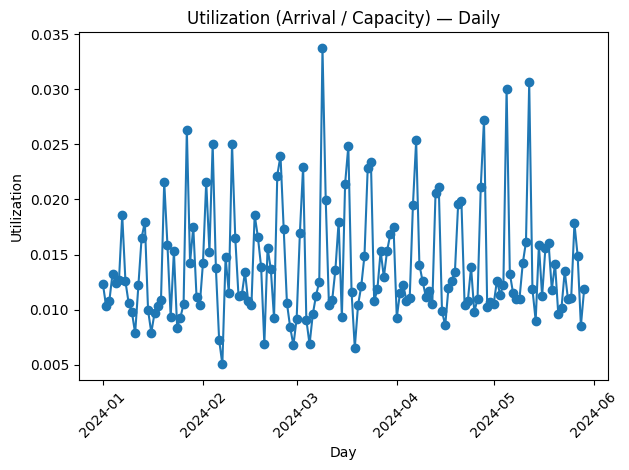

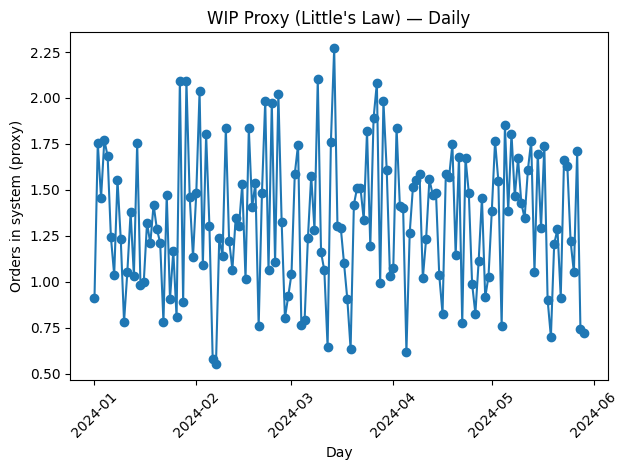

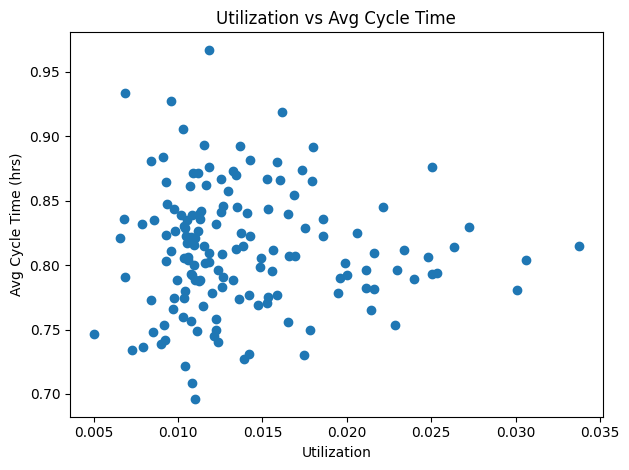

In [8]:
plt.figure()
plt.plot(pd.to_datetime(daily2["day"]), daily2["utilization"], marker="o")
plt.title("Utilization (Arrival / Capacity) — Daily")
plt.xlabel("Day")
plt.ylabel("Utilization")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(pd.to_datetime(daily2["day"]), daily2["wip_proxy_orders"], marker="o")
plt.title("WIP Proxy (Little's Law) — Daily")
plt.xlabel("Day")
plt.ylabel("Orders in system (proxy)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure()
plt.scatter(daily2["utilization"], daily2["avg_cycle_time_hrs"])
plt.title("Utilization vs Avg Cycle Time")
plt.xlabel("Utilization")
plt.ylabel("Avg Cycle Time (hrs)")
plt.tight_layout()
plt.show()


## Step 3A — Predictive Scenario A: Uniform Demand Shock

**Cell ID:** `3A`

Uniform shock is expected to scale utilization proportionally.

,day,utilization,utilization_future_A,util_ratio_A
0,2024-01-01,0.012368,0.014223,1.15
1,2024-01-02,0.010333,0.011883,1.15
2,2024-01-03,0.010761,0.012375,1.15
3,2024-01-04,0.013255,0.015243,1.15
4,2024-01-05,0.012376,0.014233,1.15
5,2024-01-06,0.012680,0.014582,1.15
6,2024-01-07,0.018578,0.021365,1.15
7,2024-01-08,0.012555,0.014438,1.15
8,2024-01-09,0.010579,0.012166,1.15
9,2024-01-10,0.009770,0.011235,1.15


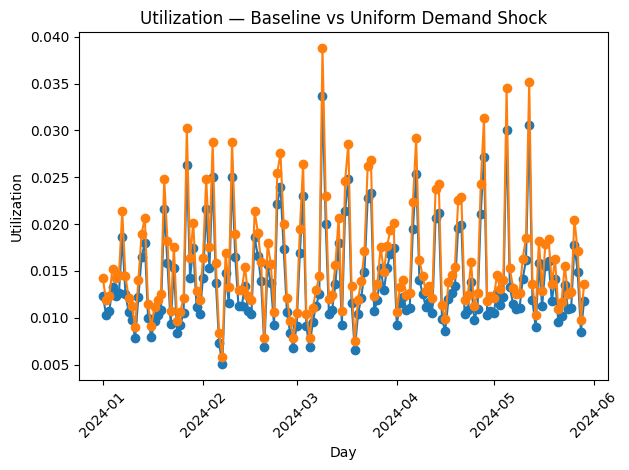

In [9]:
DEMAND_MULTIPLIER = 1.15

daily2["arrival_rate_future_A"] = daily2["total_picks"] * DEMAND_MULTIPLIER / daily2["shift_hours"]
daily2["utilization_future_A"] = daily2["arrival_rate_future_A"] / (daily2["workers"] * daily2["pick_rate_picks_per_lh"])

daily2["util_ratio_A"] = daily2["utilization_future_A"] / daily2["utilization"]
display(daily2[["day","utilization","utilization_future_A","util_ratio_A"]].head(12))

plt.figure()
plt.plot(pd.to_datetime(daily2["day"]), daily2["utilization"], marker="o")
plt.plot(pd.to_datetime(daily2["day"]), daily2["utilization_future_A"], marker="o")
plt.title("Utilization — Baseline vs Uniform Demand Shock")
plt.xlabel("Day")
plt.ylabel("Utilization")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Step 3B — Predictive Scenario B: Peak-Day Shock

**Cell ID:** `3B`

This makes the shock non-uniform so dashboards show a meaningful pattern.

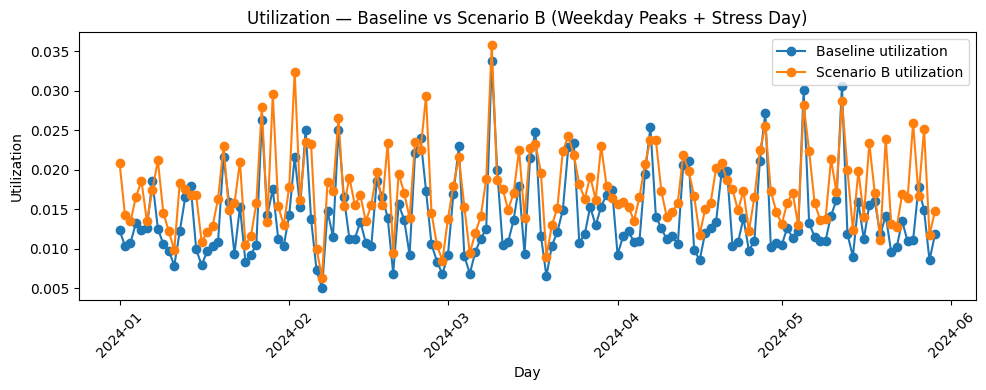

,day,weekday,demand_multiplier_B,utilization,utilization_future_B
0,2024-01-01,0,1.6875,0.012368,0.020871
1,2024-01-02,1,1.3750,0.010333,0.014208
2,2024-01-03,2,1.2500,0.010761,0.013451
3,2024-01-04,3,1.2500,0.013255,0.016569
4,2024-01-05,4,1.5000,0.012376,0.018564
5,2024-01-06,5,1.0625,0.012680,0.013472
6,2024-01-07,6,0.9375,0.018578,0.017417
7,2024-01-08,0,1.6875,0.012555,0.021187
8,2024-01-09,1,1.3750,0.010579,0.014546
9,2024-01-10,2,1.2500,0.009770,0.012212


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Scenario B: Non-uniform workload (weekday pattern) + optional single-day shock
# Design goal: dashboards show meaningful variation and staffing decisions change by day.

BASE_UPLIFT = 1.25

weekday_multiplier = {
    0: 1.35,  # Monday peak
    1: 1.10,
    2: 1.00,
    3: 1.00,
    4: 1.20,  # Friday bump
    5: 0.85,
    6: 0.75
}

ENABLE_SINGLE_SHOCK_DAY = True
SINGLE_DAY_SHOCK_MULT = 2.20

# Calibration constant (keeps ratios intact, makes staffing levels visible)
VOLUME_SCALE = 1.00

tmp_days = pd.to_datetime(daily2["day"])
daily2["weekday"] = tmp_days.dt.weekday

# Baseline arrival rate (picks/hour)
daily2["arrival_rate"] = daily2["total_picks"] / daily2["shift_hours"]

daily2["demand_multiplier_B"] = BASE_UPLIFT * daily2["weekday"].map(weekday_multiplier).astype(float)
daily2["arrival_rate_future_B"] = daily2["arrival_rate"] * daily2["demand_multiplier_B"] * VOLUME_SCALE

if ENABLE_SINGLE_SHOCK_DAY:
    shock_day = tmp_days.iloc[-5]
    daily2.loc[tmp_days == shock_day, "arrival_rate_future_B"] *= SINGLE_DAY_SHOCK_MULT

daily2["utilization_future_B"] = daily2["arrival_rate_future_B"] / (daily2["workers"] * daily2["pick_rate_picks_per_lh"])

plt.figure(figsize=(10,4))
plt.plot(tmp_days, daily2["utilization"], marker="o", label="Baseline utilization")
plt.plot(tmp_days, daily2["utilization_future_B"], marker="o", label="Scenario B utilization")
plt.title("Utilization — Baseline vs Scenario B (Weekday Peaks + Stress Day)")
plt.xlabel("Day")
plt.ylabel("Utilization")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

display(daily2[["day","weekday","demand_multiplier_B","utilization","utilization_future_B"]].head(12))


## Step 3C — Predictive + Congestion: Cycle Time Response

**Cell ID:** `3C`

This introduces a simple congestion response so cycle time is no longer flat under shocks.

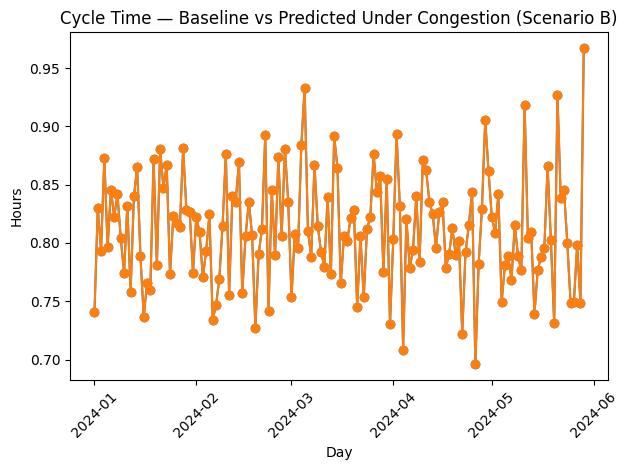

,day,utilization_future_B,cong_mult_B,cycle_time_pred_B
0,2024-01-01,0.020871,1.0,0.740396
1,2024-01-02,0.014208,1.0,0.830293
2,2024-01-03,0.013451,1.0,0.793457
3,2024-01-04,0.016569,1.0,0.873308
4,2024-01-05,0.018564,1.0,0.796552
5,2024-01-06,0.013472,1.0,0.845824
6,2024-01-07,0.017417,1.0,0.822221
7,2024-01-08,0.021187,1.0,0.841605
8,2024-01-09,0.014546,1.0,0.804026
9,2024-01-10,0.012212,1.0,0.774324


In [11]:
CONGESTION_MODEL_ON = True
UTIL_THRESHOLD = 0.85
CONGESTION_SLOPE = 1.8   # larger -> stronger blow-up beyond threshold

def congestion_multiplier(u, threshold=0.85, slope=1.8):
    # smooth blow-up beyond threshold; multiplier >= 1
    u = np.asarray(u, dtype=float)
    base = np.ones_like(u)
    excess = np.maximum(u - threshold, 0.0)
    # grows fast as utilization increases
    base = 1.0 + (excess / max(1e-9, (1.0 - threshold)))**slope
    return base

if CONGESTION_MODEL_ON:
    # use scenario B utilization to show interesting pattern
    daily2["cong_mult_B"] = congestion_multiplier(daily2["utilization_future_B"], UTIL_THRESHOLD, CONGESTION_SLOPE)
    daily2["cycle_time_pred_B"] = daily2["avg_cycle_time_hrs"] * daily2["cong_mult_B"]
else:
    daily2["cycle_time_pred_B"] = daily2["avg_cycle_time_hrs"]

plt.figure()
plt.plot(pd.to_datetime(daily2["day"]), daily2["avg_cycle_time_hrs"], marker="o")
plt.plot(pd.to_datetime(daily2["day"]), daily2["cycle_time_pred_B"], marker="o")
plt.title("Cycle Time — Baseline vs Predicted Under Congestion (Scenario B)")
plt.xlabel("Day")
plt.ylabel("Hours")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

display(daily2[["day","utilization_future_B","cong_mult_B","cycle_time_pred_B"]].head(12))


## Step 4A — Prescriptive: Define Target Utilization

**Cell ID:** `4A`

In [12]:
TARGET_UTIL = 0.85
TARGET_UTIL

0.85

## Step 4B — Prescriptive: Required Staffing by Day

**Cell ID:** `4B`

Compute workers needed to hit target utilization under Scenario B.

,day,weekday,workers,workers_lost,workers_effective,pick_rate_picks_per_lh,congestion_factor,pick_rate_effective,arrival_rate_future_B,workers_required_B_raw,workers_required_B,staffing_gap_B_raw,staffing_gap_B
0,2024-01-01,0,8.0,1.0,7.0,368.423481,0.70,257.896436,61.514778,0.280618,1.0,-6.719382,-6.0
1,2024-01-02,1,11.0,0.0,11.0,216.663775,0.85,184.164209,33.861940,0.216316,1.0,-10.783684,-10.0
2,2024-01-03,2,10.0,0.0,10.0,238.858945,1.00,238.858945,32.129743,0.158251,1.0,-9.841749,-9.0
3,2024-01-04,3,10.0,0.0,10.0,248.606724,1.00,248.606724,41.191381,0.194928,1.0,-9.805072,-9.0
4,2024-01-05,4,9.0,1.0,8.0,227.793134,0.75,170.844851,38.059701,0.262086,1.0,-7.737914,-7.0
5,2024-01-06,5,7.0,3.0,4.0,223.671021,1.05,234.854572,21.093750,0.105666,1.0,-3.894334,-3.0
6,2024-01-07,6,4.0,4.0,1.0,258.259713,1.10,284.085685,17.992424,0.074511,1.0,-0.925489,0.0
7,2024-01-08,0,10.0,1.0,9.0,295.615735,0.70,206.931014,62.631011,0.356078,1.0,-8.643922,-8.0
8,2024-01-09,1,9.0,0.0,9.0,265.600217,0.85,225.760185,34.770115,0.181192,1.0,-8.818808,-8.0
9,2024-01-10,2,9.0,0.0,9.0,273.177029,1.00,273.177029,30.025284,0.129308,1.0,-8.870692,-8.0


,workers,workers_effective,pick_rate_picks_per_lh,pick_rate_effective,arrival_rate_future_B,workers_required_B_raw,workers_required_B,staffing_gap_B_raw,staffing_gap_B
count,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000
mean,8.533333,7.306667,277.744573,248.241204,46.380822,0.203848,1.006667,-7.102819,-6.300000
std,2.064941,3.393532,116.953937,95.571847,54.737722,0.107471,0.081650,3.361849,3.395121
min,4.000000,1.000000,140.529613,154.582574,12.172285,0.059207,1.000000,-10.918525,-10.000000
25%,7.000000,4.000000,212.182885,207.390792,27.375484,0.138301,1.000000,-9.800974,-9.000000
50%,9.000000,9.000000,257.109458,233.135779,35.489452,0.184049,1.000000,-8.694145,-8.000000
75%,10.000000,10.000000,310.444433,261.258202,50.041258,0.241530,1.000000,-3.859016,-3.000000
max,11.000000,11.000000,1134.837859,964.612180,439.112903,1.012183,2.000000,-0.785636,0.000000


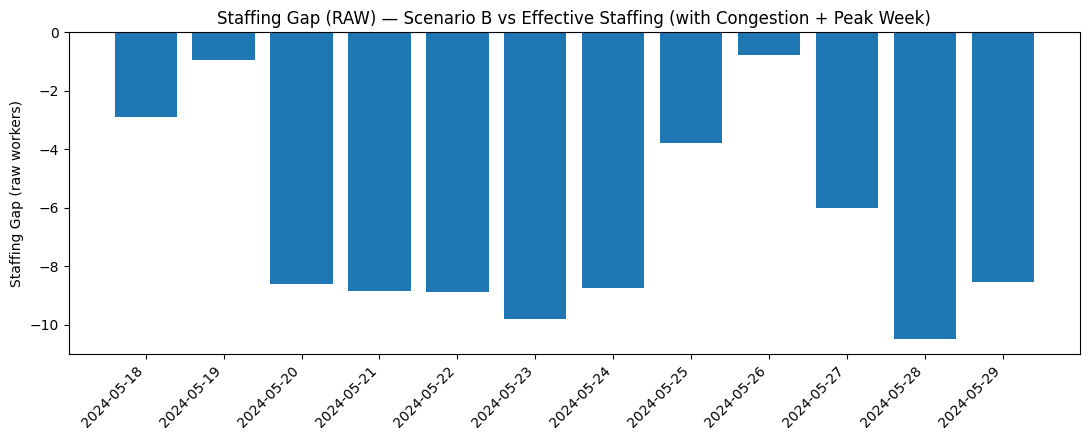

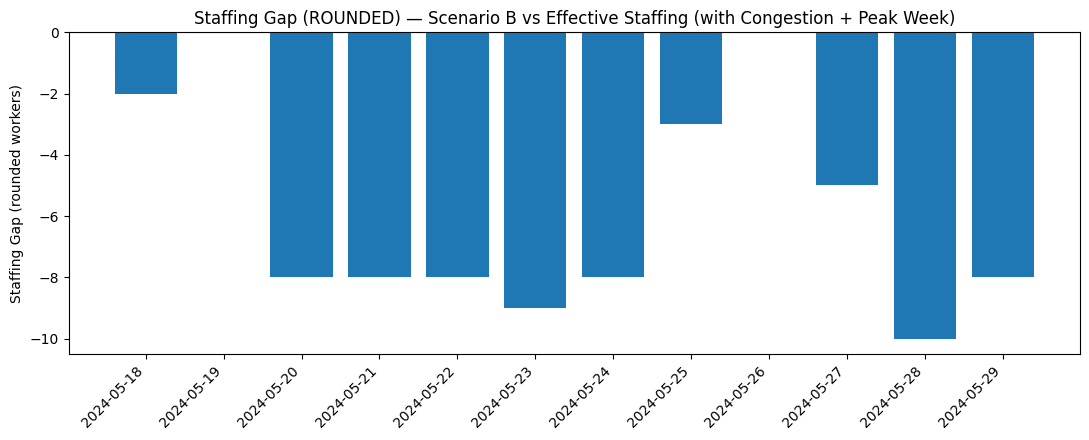

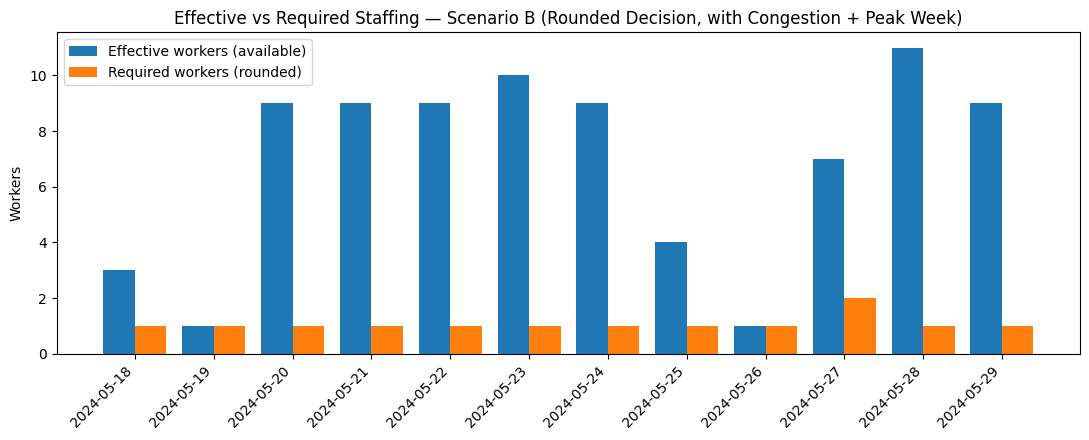

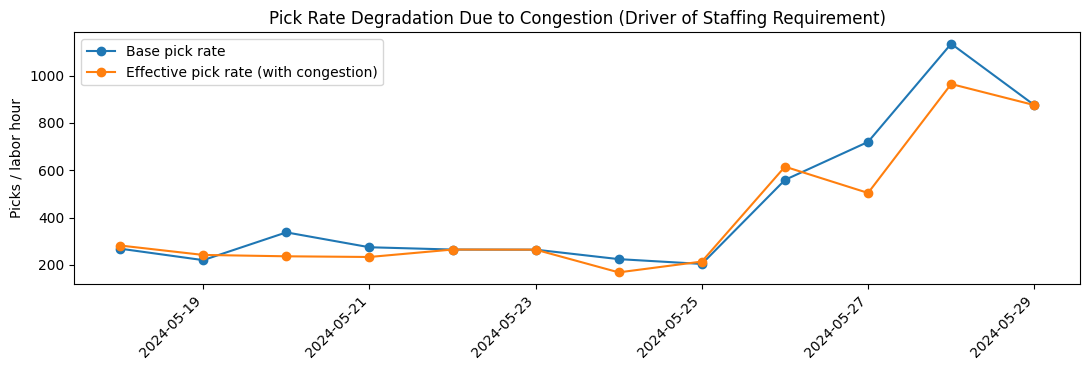

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# ---------------------------------------------
# 4B1) Create "effective workers" (dynamic capacity)
# ---------------------------------------------
workers_lost_by_weekday = {
    0: 1,  # Mon: absenteeism / onboarding
    1: 0,
    2: 0,
    3: 0,
    4: 1,  # Fri: early shift-outs
    5: 3,  # Sat: skeleton crew
    6: 4   # Sun: minimal crew
}

daily2["day"] = pd.to_datetime(daily2["day"])
if "weekday" not in daily2.columns:
    daily2["weekday"] = daily2["day"].dt.weekday

daily2["workers_lost"] = daily2["weekday"].map(workers_lost_by_weekday).astype(float)
daily2["workers_effective"] = (daily2["workers"] - daily2["workers_lost"]).clip(lower=1)

# ---------------------------------------------
# 4B1b) Add "effective pick rate" (congestion / fatigue / travel distance)
# ---------------------------------------------
congestion_factor_by_weekday = {
    0: 0.70,  # Mon peak congestion
    1: 0.85,
    2: 1.00,
    3: 1.00,
    4: 0.75,  # Fri congestion + fatigue
    5: 1.05,  # Sat smoother flow (fewer inbound conflicts)
    6: 1.10   # Sun light operations
}

daily2["congestion_factor"] = daily2["weekday"].map(congestion_factor_by_weekday).astype(float)
daily2["pick_rate_effective"] = (daily2["pick_rate_picks_per_lh"] * daily2["congestion_factor"]).clip(lower=1e-6)

# ---------------------------------------------
# 4B1c) Peak week stress test (teaching lever)
# ---------------------------------------------
# Goal: force a few days into constraint so the staffing dashboard becomes interpretable.
ENABLE_PEAK_WEEK = True
PEAK_WEEK_MULT = 3.0   # try 3.5 if required is still below available
PEAK_DAYS = 4          # how many last days are treated as peak days

df_days = pd.to_datetime(daily2["day"])
peak_window = df_days.isin(df_days.sort_values().tail(PEAK_DAYS))

# Apply peak multiplier directly to Scenario B arrival rate (picks/hour)
if ENABLE_PEAK_WEEK:
    daily2.loc[peak_window, "arrival_rate_future_B"] *= PEAK_WEEK_MULT

# ---------------------------------------------
# 4B2) Required staffing under Scenario B (use EFFECTIVE pick rate)
# ---------------------------------------------
daily2["workers_required_B_raw"] = daily2["arrival_rate_future_B"] / (TARGET_UTIL * daily2["pick_rate_effective"])
daily2["workers_required_B"] = np.ceil(daily2["workers_required_B_raw"])

# ---------------------------------------------
# 4B3) Staffing gaps (use EFFECTIVE workers)
# ---------------------------------------------
daily2["staffing_gap_B_raw"] = daily2["workers_required_B_raw"] - daily2["workers_effective"]
daily2["staffing_gap_B"] = daily2["workers_required_B"] - daily2["workers_effective"]

display(daily2[[
    "day","weekday",
    "workers","workers_lost","workers_effective",
    "pick_rate_picks_per_lh","congestion_factor","pick_rate_effective",
    "arrival_rate_future_B",
    "workers_required_B_raw","workers_required_B",
    "staffing_gap_B_raw","staffing_gap_B"
]].head(12))

display(daily2[[
    "workers","workers_effective",
    "pick_rate_picks_per_lh","pick_rate_effective",
    "arrival_rate_future_B",
    "workers_required_B_raw","workers_required_B",
    "staffing_gap_B_raw","staffing_gap_B"
]].describe())

# ---------------------------------------------
# 4B4) Dashboards
# ---------------------------------------------
daily2["workers_required_total_B"] = daily2["workers_effective"] + daily2["staffing_gap_B"].clip(lower=0)

N = 12
dfp = daily2.sort_values("day").tail(N).copy()
x = np.arange(len(dfp))

# Dashboard View 1: RAW staffing gap (continuous signal)
plt.figure(figsize=(11,4.5))
plt.bar(x, dfp["staffing_gap_B_raw"])
plt.axhline(0)
plt.xticks(x, dfp["day"].dt.strftime("%Y-%m-%d"), rotation=45, ha="right")
plt.ylabel("Staffing Gap (raw workers)")
plt.title("Staffing Gap (RAW) — Scenario B vs Effective Staffing (with Congestion + Peak Week)")
plt.tight_layout()
plt.show()

# Dashboard View 2: Rounded decision gap (headcount reality)
plt.figure(figsize=(11,4.5))
plt.bar(x, dfp["staffing_gap_B"])
plt.axhline(0)
plt.xticks(x, dfp["day"].dt.strftime("%Y-%m-%d"), rotation=45, ha="right")
plt.ylabel("Staffing Gap (rounded workers)")
plt.title("Staffing Gap (ROUNDED) — Scenario B vs Effective Staffing (with Congestion + Peak Week)")
plt.tight_layout()
plt.show()

# Dashboard View 3: Effective vs TOTAL required (side-by-side) — ROUNDED decision
# Interpretation: compares available execution capacity vs the total headcount needed to hit TARGET_UTIL under Scenario B.
w = 0.40
plt.figure(figsize=(11,4.5))
plt.bar(x - w/2, dfp["workers_effective"], width=w, label="Effective workers (available)")
plt.bar(x + w/2, dfp["workers_required_total_B"], width=w, label="Total workers required (rounded)")
plt.xticks(x, dfp["day"].dt.strftime("%Y-%m-%d"), rotation=45, ha="right")
plt.ylabel("Workers")
plt.title("Effective vs Total Required Staffing — Scenario B (Rounded Decision, with Congestion + Peak Week)")
plt.legend()
plt.tight_layout()
plt.show()

# Optional: show the pick rate degradation itself (why required rises)
plt.figure(figsize=(11,3.8))
plt.plot(dfp["day"], dfp["pick_rate_picks_per_lh"], marker="o", label="Base pick rate")
plt.plot(dfp["day"], dfp["pick_rate_effective"], marker="o", label="Effective pick rate (with congestion)")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Picks / labor hour")
plt.title("Pick Rate Degradation Due to Congestion (Driver of Staffing Requirement)")
plt.legend()
plt.tight_layout()
plt.show()


## Why uniform shock looks “constant”
If demand increases uniformly and capacity assumptions are fixed, then utilization scales proportionally:
util_future = util_base × multiplier  
So the **ratio** is constant and that is expected.

To make dashboards interesting and realistic, Scenario B creates a peak-day shock, and Step 3C adds congestion response so cycle time changes non-linearly.
